In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

2023-05-05 20:51:19.305751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5154 files belonging to 3 classes.
Using 4124 files for training.
Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [3]:
# number and names of Classes
classnames = train_ds.class_names
len(classnames),train_ds.class_names

(3, ['AD', 'CN', 'MCI'])

2023-05-05 20:51:48.484724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4124]
	 [[{{node Placeholder/_4}}]]
2023-05-05 20:51:48.485332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4124]
	 [[{{node Placeholder/_0}}]]


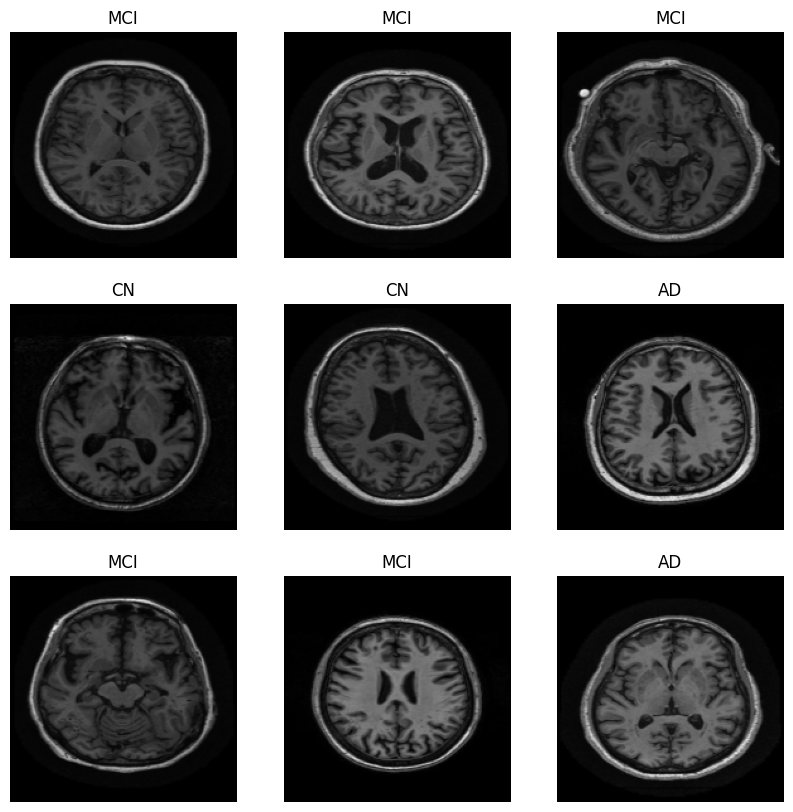

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [5]:
# Number of images in each class
NUM_IMAGES = []

for label in classnames:
    dir_name = "Dataset" +'/'+ label
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

NUM_IMAGES,classnames

([1124, 1440, 2590], ['AD', 'CN', 'MCI'])

In [6]:
train_ds.class_names = classnames
val_ds.class_names = classnames

NUM_CLASSES = len(classnames)
NUM_CLASSES

3

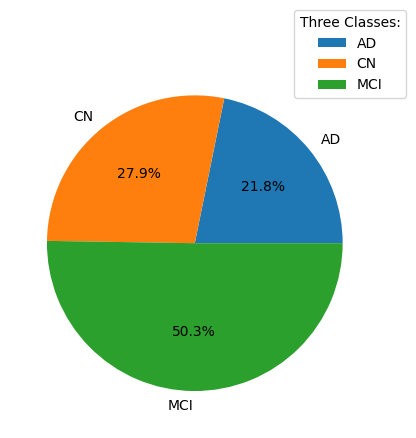

In [7]:
# Before Oversampling
# Visualization of each class with pie chart
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(NUM_IMAGES, autopct='%1.1f%%',labels=train_ds.class_names)
plt.legend(title = "Three Classes:",bbox_to_anchor =(0.75, 1.15))

In [8]:
# Performing Image Augmentation to have more data samples
IMG_SIZE = 180
IMAGE_SIZE = [180, 180]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR="Dataset"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=8000, shuffle=False)

Found 5154 images belonging to 3 classes.


In [9]:
train_data, train_labels = train_data_gen.next()

In [10]:
# Shape of data before oversampling
print(train_data.shape, train_labels.shape)

(5154, 180, 180, 3) (5154, 3)


In [11]:
# Performing over-sampling of the data, since the classes are imbalanced
# After oversampling using SMOTE
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(7770, 180, 180, 3) (7770, 3)


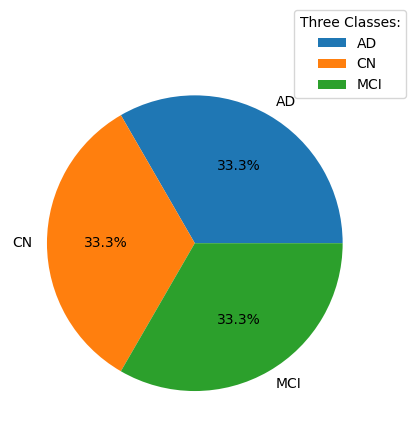

In [12]:
# Show pie plot for dataset (after oversampling)
# Visualization of each class with pie chart
images_after = [2590,2590,2590]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(images_after, autopct='%1.1f%%',labels=train_ds.class_names)
plt.legend(title = "Three Classes:",bbox_to_anchor =(0.75, 1.15))

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [14]:
#-------DenseNet121--------

vgg = DenseNet121(input_shape=(180,180,3),weights='imagenet',include_top=False)
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input,outputs=prediction)

In [22]:
# Optimizing model
modelvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

modelvgg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1/conv[0][0]']         

In [16]:
# Fitting the model
hist = modelvgg.fit(
           train_data, train_labels,
           epochs=15,validation_data=(val_data, val_labels),
            callbacks=[checkpoint, lr_reduce])

Epoch 1/15
156/156 [==============================] - 353s 2s/step - loss: 1.8569 - accuracy: 0.5847 - val_loss: 0.5300 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 2/15
156/156 [==============================] - 314s 2s/step - loss: 0.4296 - accuracy: 0.8258 - val_loss: 1.4470 - val_accuracy: 0.6407 - lr: 0.0010
Epoch 3/15
156/156 [==============================] - 315s 2s/step - loss: 0.3405 - accuracy: 0.8733 - val_loss: 0.4618 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9413
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
156/156 [==============================] - 317s 2s/step - loss: 0.1732 - accuracy: 0.9413 - val_loss: 0.3323 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 5/15
156/156 [==============================] - 318s 2s/step - loss: 0.0943 - accuracy: 0.9787 - val_loss: 0.1534 - val_accuracy: 0.9534 - lr: 3.0000e-04
Epoch 6/15
156/156 [==============================] - E

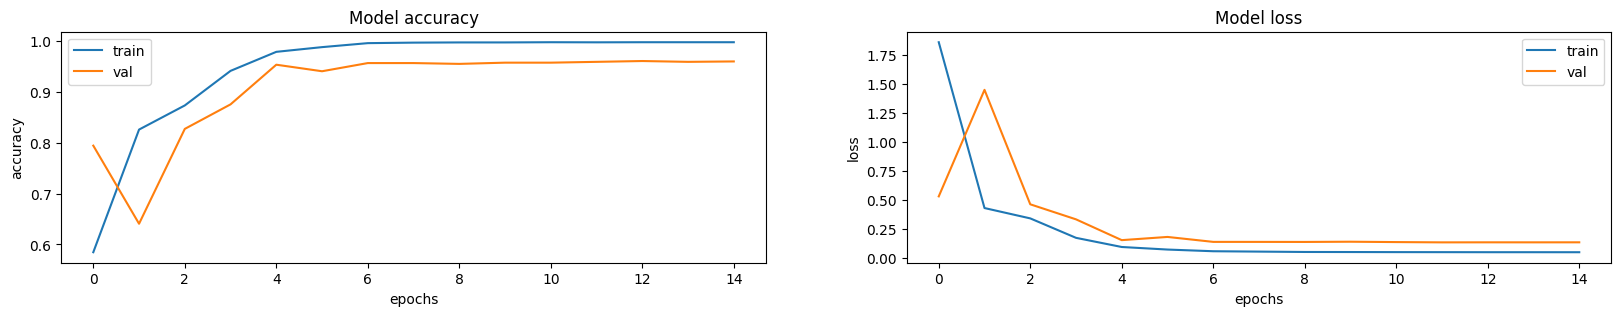

In [17]:
# Plotting accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
# Evaluation using test data
test_scores = modelvgg.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

49/49 [==============================] - 78s 2s/step - loss: 0.1392 - accuracy: 0.9556
Testing Accuracy: 95.56%


In [19]:
pred_labels = modelvgg.predict(test_data)

49/49 [==============================] - 77s 2s/step


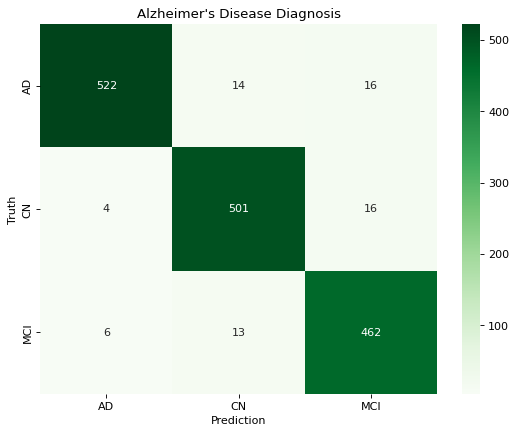

In [20]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [21]:
print(classification_report(test_ls, pred_ls, target_names=classnames))

              precision    recall  f1-score   support

          AD       0.98      0.95      0.96       552
          CN       0.95      0.96      0.96       521
         MCI       0.94      0.96      0.95       481

    accuracy                           0.96      1554
   macro avg       0.96      0.96      0.96      1554
weighted avg       0.96      0.96      0.96      1554

